In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import pandas as pd
import numpy as np
import sys
from io import StringIO
import glob
if not hasattr(sys, "version_info") or sys.version_info < (3, 5):
  raise SystemExit("This program requires Python 3.5 or later.")
import csv
import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import os
import requests
from bs4 import BeautifulSoup
import urllib
## https://github.com/ipython/ipyparallel
import ipyparallel as ipp
workers = ipp.Client()[:]
data_files = glob.glob("data[0-9][0-9][0-9].csv")
csvDelimiter = ";"
dataTypes = {'time': 'datetime64','humidity': 'float', 'temperature': 'float'}
dataHeaders = ['time','humidity', 'temperature']
httpsource = "http://192.168.0.6/"
plt.rcParams['figure.figsize'] = [30/2.54, 20/2.54]
data_files

['data000.csv', 'data001.csv', 'data002.csv', 'data003.csv', 'data004.csv']

In [3]:
def get_url_paths(url, ext='', params={}):
    response = requests.get(url, params=params)
    if response.ok:
        response_text = response.text
    else:
        return response.raise_for_status()
    soup = BeautifulSoup(response_text, 'html.parser')
    parent = [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]
    return parent
        
remote_data_files = get_url_paths(httpsource, ".csv")
remote_data_files

['http://192.168.0.6/data000.csv',
 'http://192.168.0.6/data001.csv',
 'http://192.168.0.6/data002.csv',
 'http://192.168.0.6/data003.csv',
 'http://192.168.0.6/data004.csv']

In [4]:
%%time
## raw data merge
def readPart(fname):
    import numpy as np
    import pandas as pd  
    import requests
    from bs4 import BeautifulSoup
    import urllib
    
    def remoteRead(url) -> str:
        r = requests.get(url, stream=True)
        if r.status_code == 200:
            r.raw.decode_content = True
            return r.text
        raise requests.ConnectionError()
        
    def isUrl(text : str):
        return text.startswith("http://") or text.startswith("https://")
    
    def readFile(path: str):
        if isUrl(path):
            return remoteRead(path).replace(",", ".")
        else:
            txt = ""
            with open(fname, 'r', newline='') as infile:
                txt = infile.read().replace(",", ".")
            return txt

    from io import StringIO
    dataTypes = {'time': 'datetime64','humidity': 'float', 'temperature': 'float'}
    csvDelimiter = ";"
    indata = readFile(fname)
    return (fname, pd.read_csv(StringIO(indata), sep = csvDelimiter).astype(dataTypes))

patches = [("%s/%s" % (os.getcwd(), f)) for f in data_files]
#patches = remote_data_files
parts = workers.map_async(readPart, patches).get()

npdata = []
frames = []
for filename, frame in parts:
    l = frame.values.tolist()
    frame.columns = dataHeaders
    frames.append(frame)
    npdata.extend(l)

temperature_data = pd.DataFrame(npdata)
temperature_data.columns = dataHeaders

CPU times: user 6.2 s, sys: 276 ms, total: 6.48 s
Wall time: 54.5 s


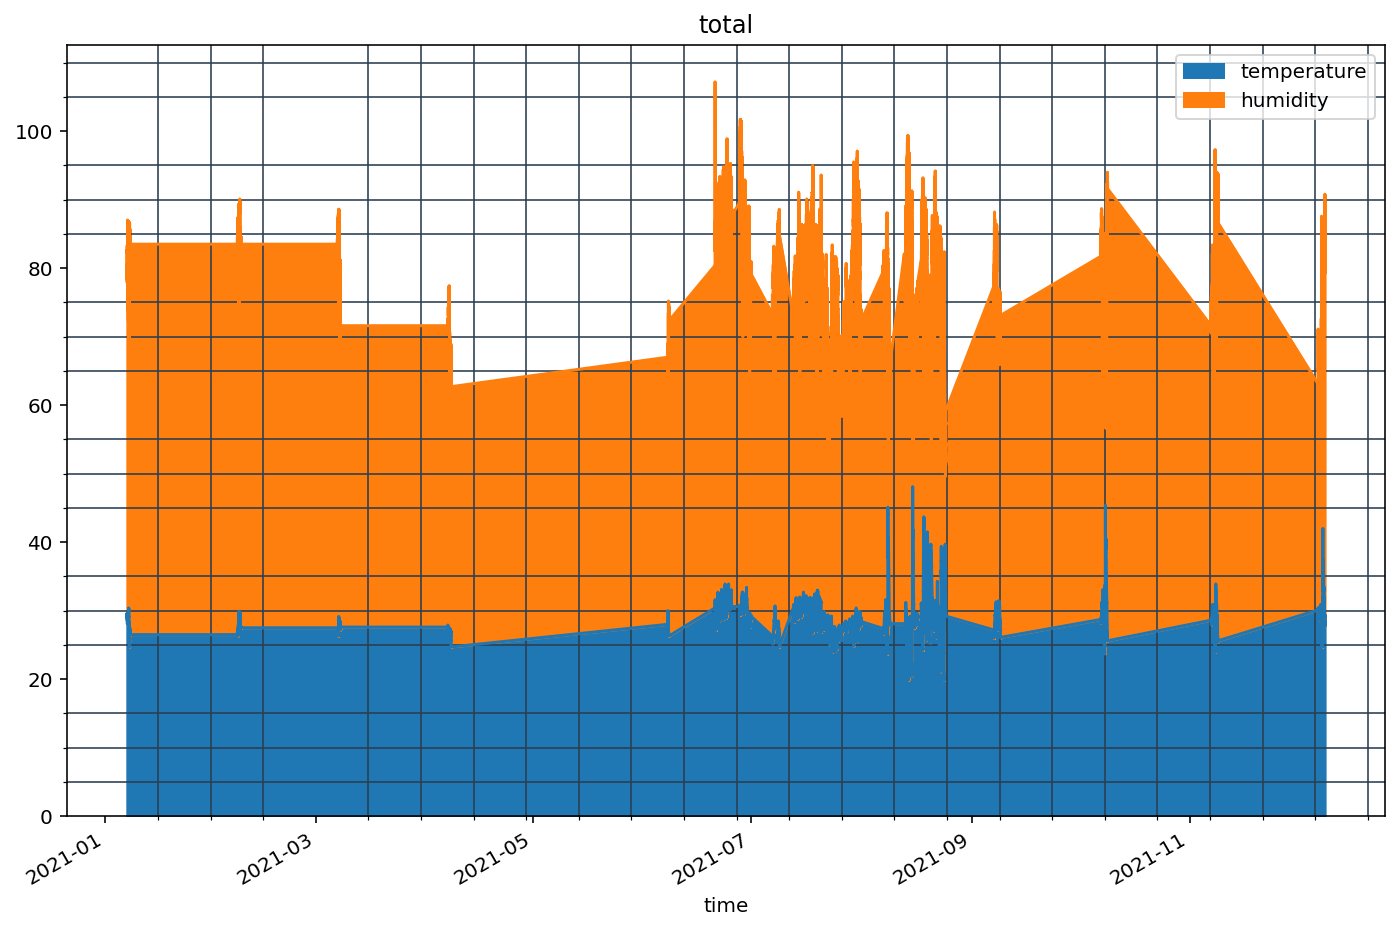

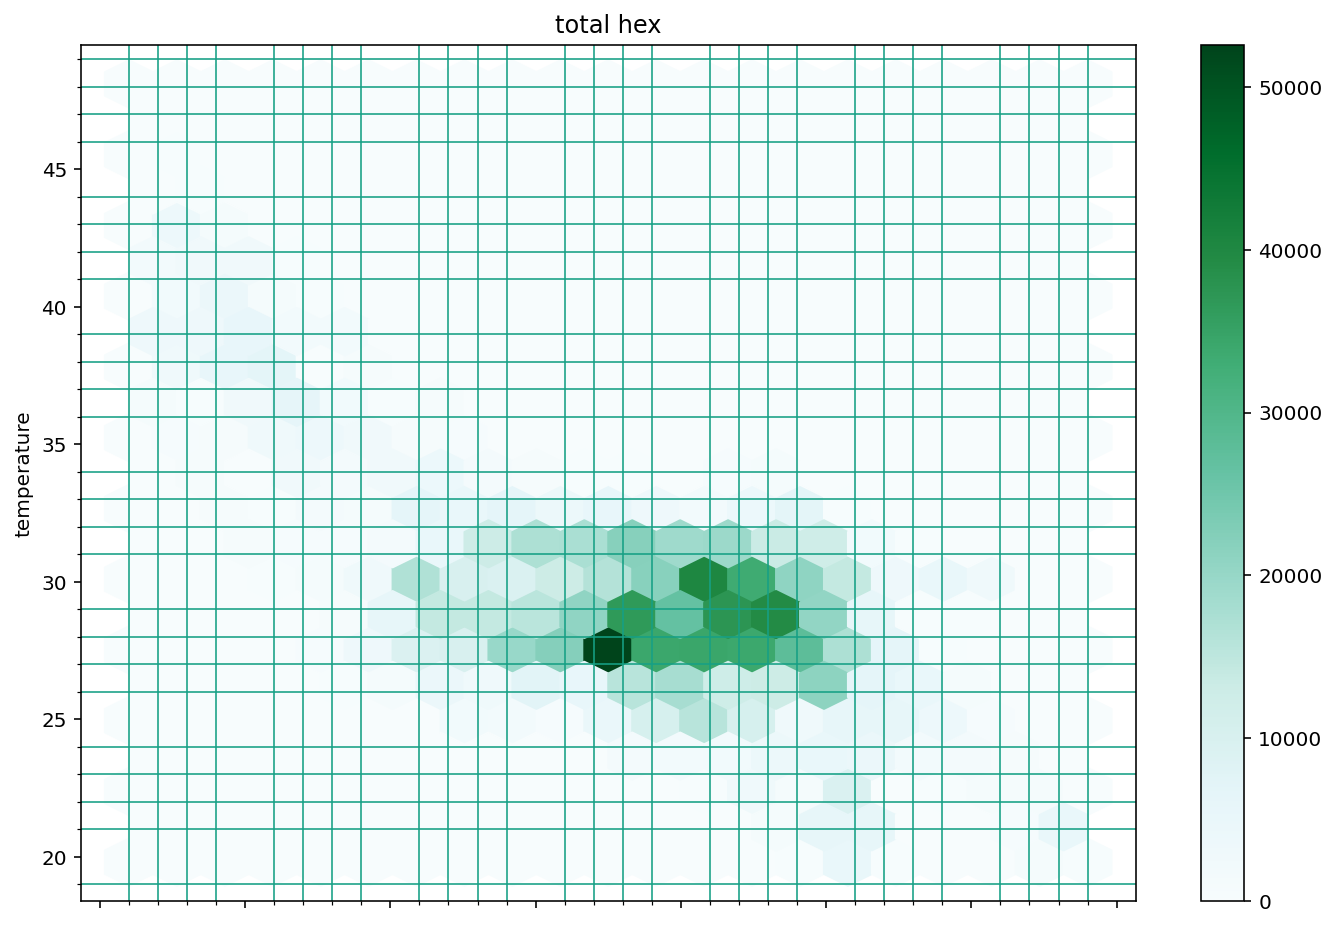

CPU times: user 10.5 s, sys: 450 ms, total: 11 s
Wall time: 11 s


In [5]:
%%time
temperature_data.plot.area(x="time", y=["temperature", "humidity"])
plt.title("total")
plt.grid(b=True, which='minor', color='#2c3e50')
plt.minorticks_on()
plt.show()

temperature_data.plot.hexbin(x="humidity", y="temperature", gridsize=20)
plt.title("total hex")
plt.grid(b=True, which='minor', color='#16a085')
plt.minorticks_on()
plt.show()

<AxesSubplot:>

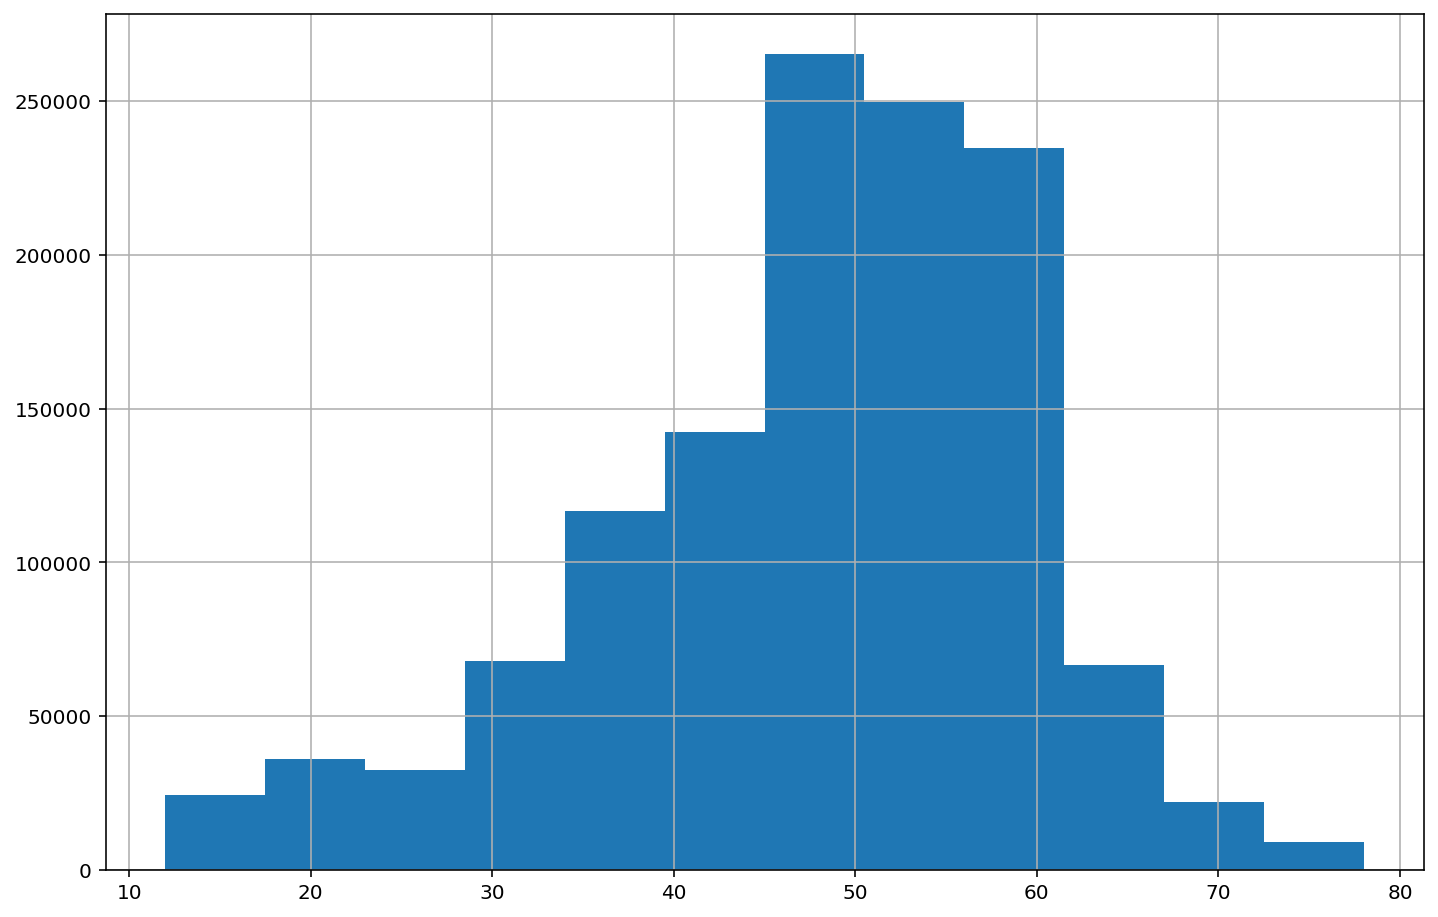

In [6]:
temperature_data['humidity'].hist(bins=12)

<AxesSubplot:>

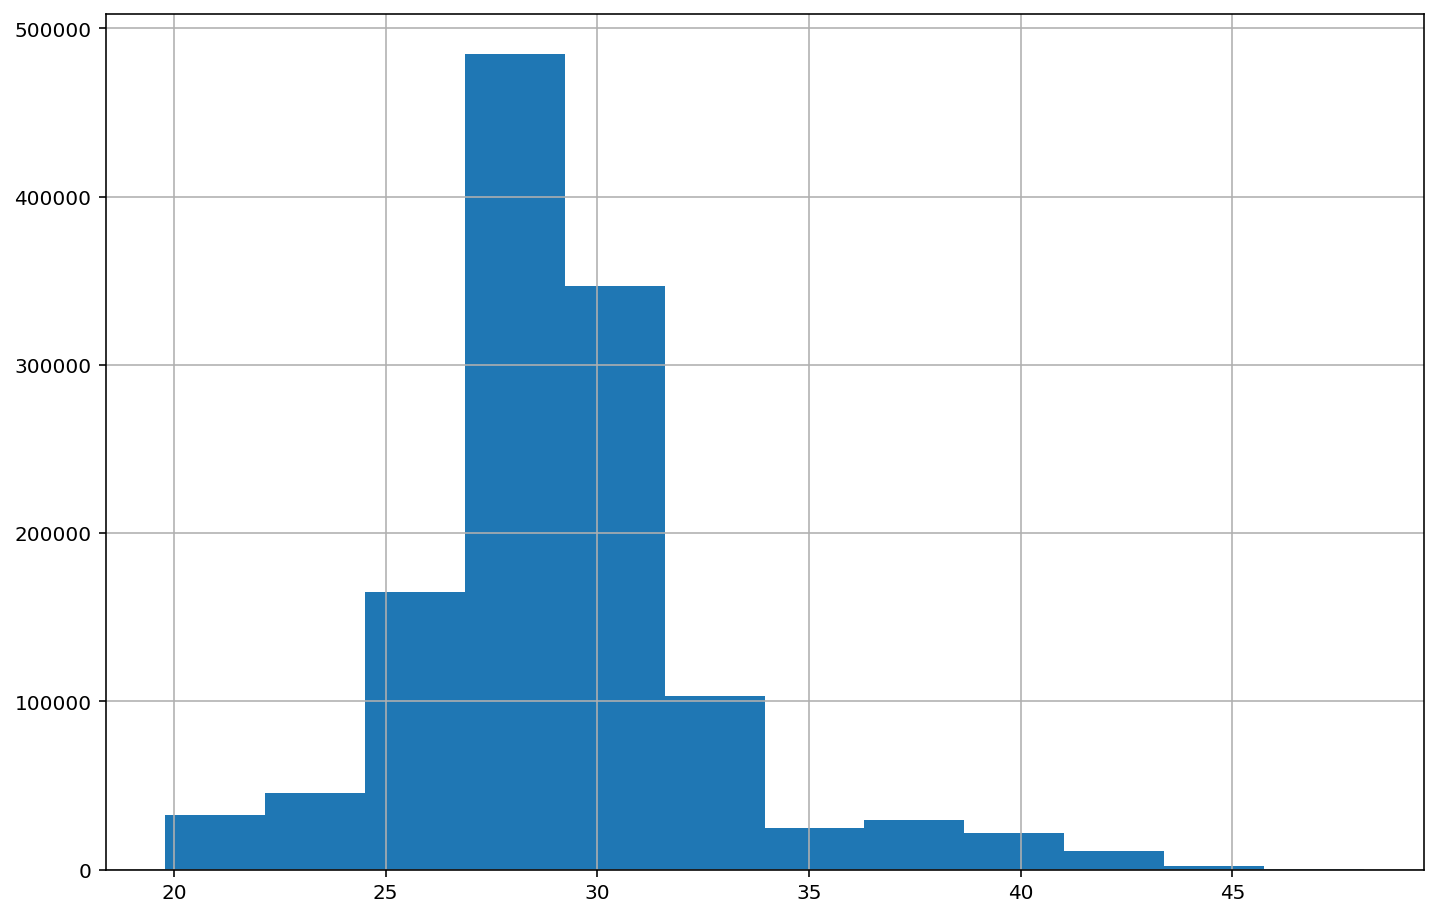

In [7]:
temperature_data['temperature'].hist(bins=12)

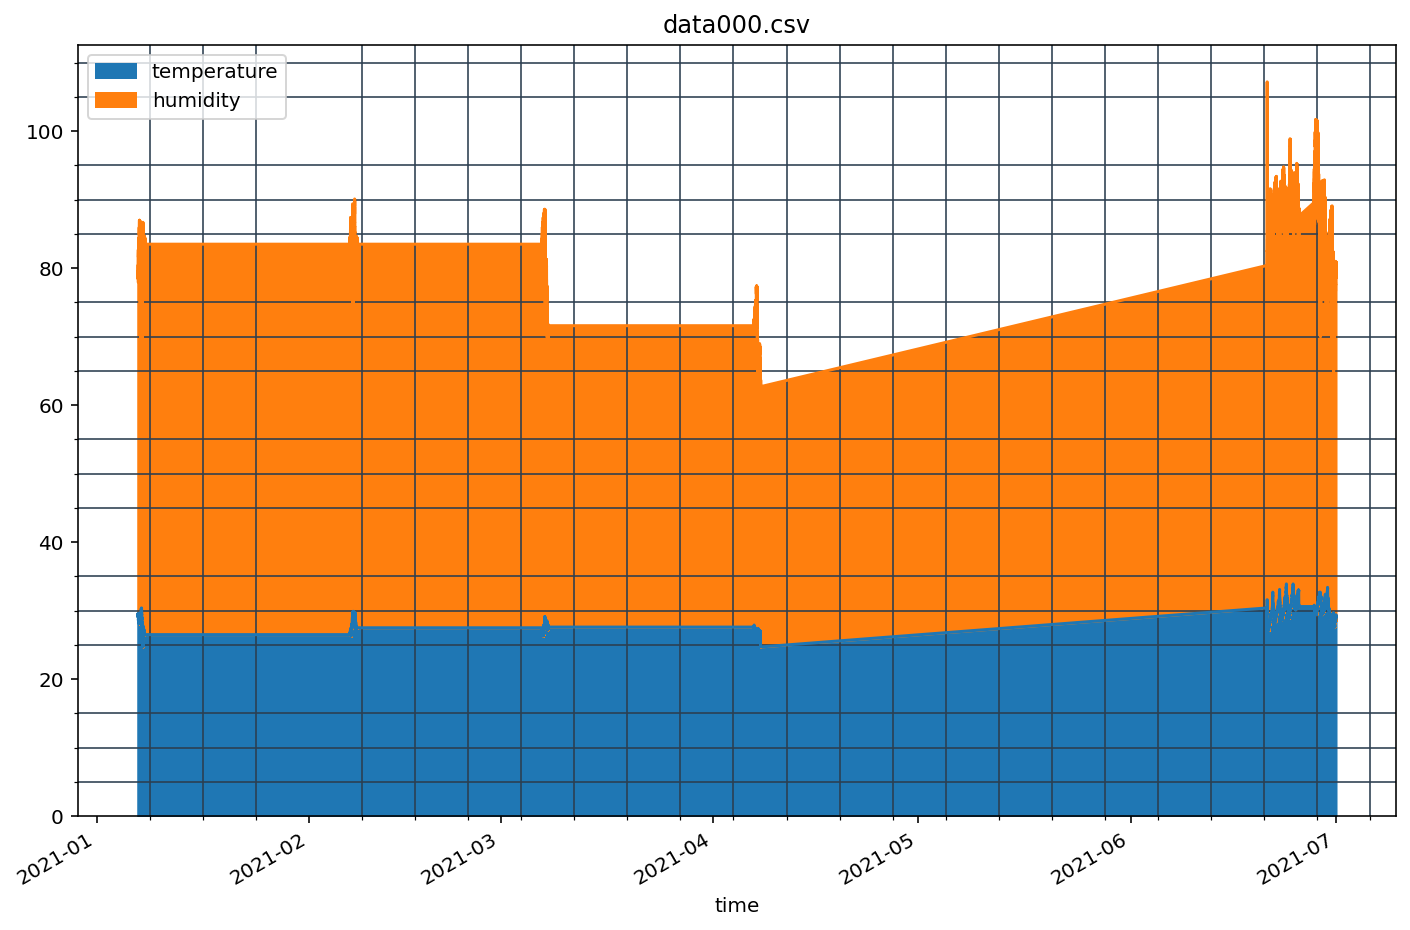

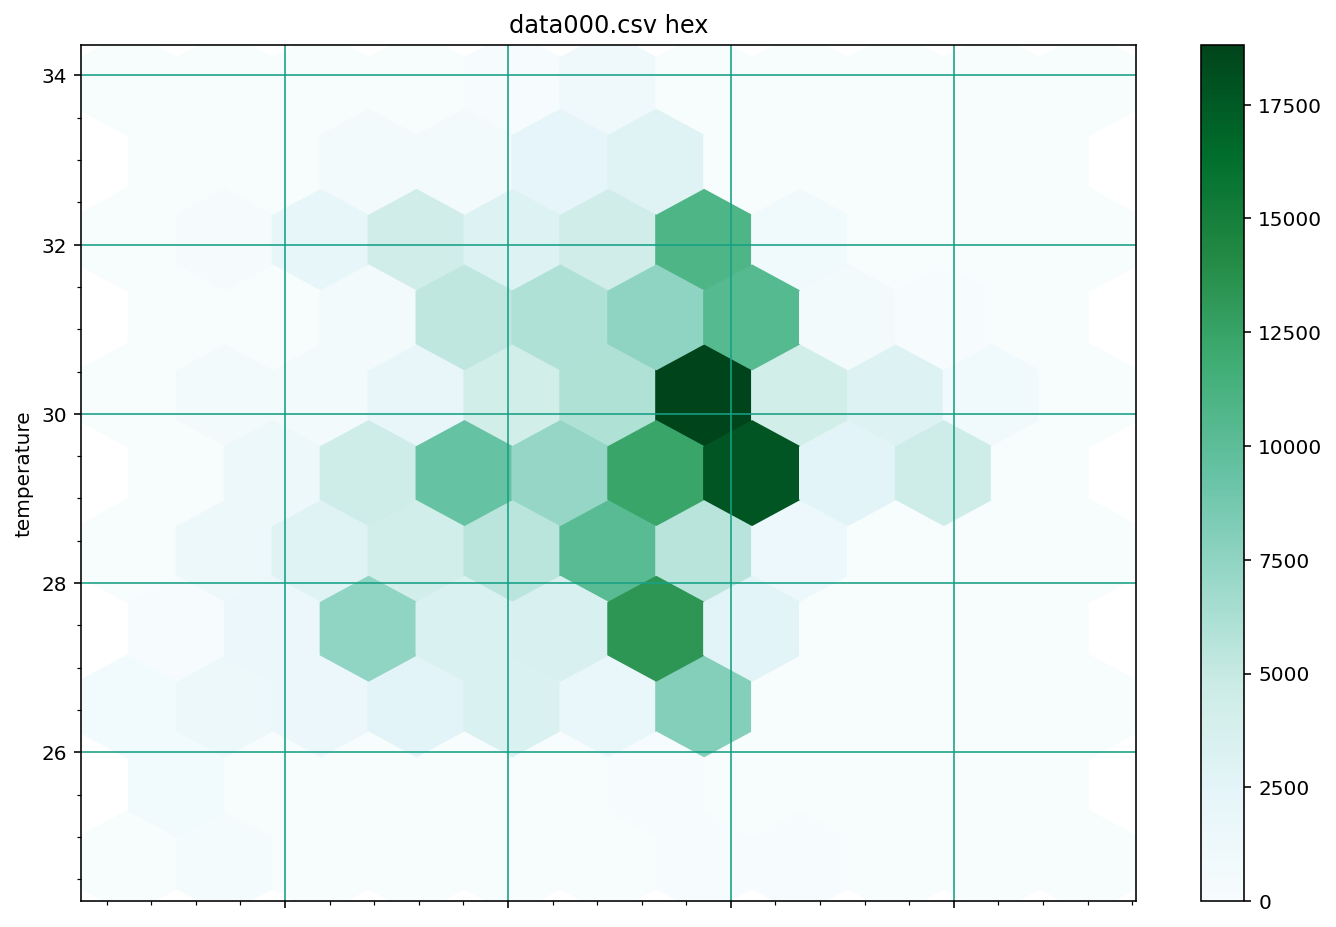

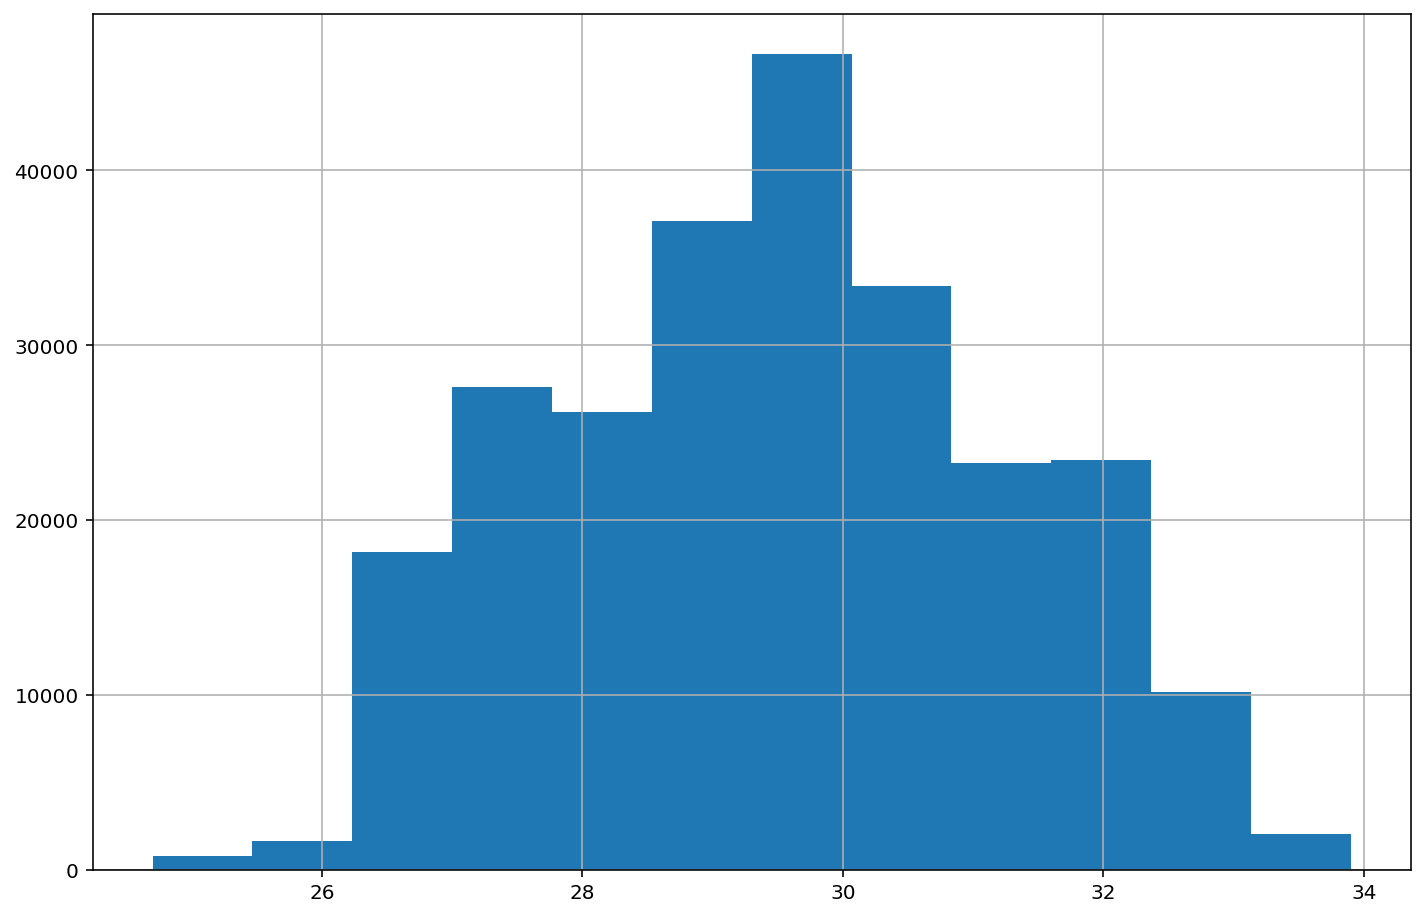

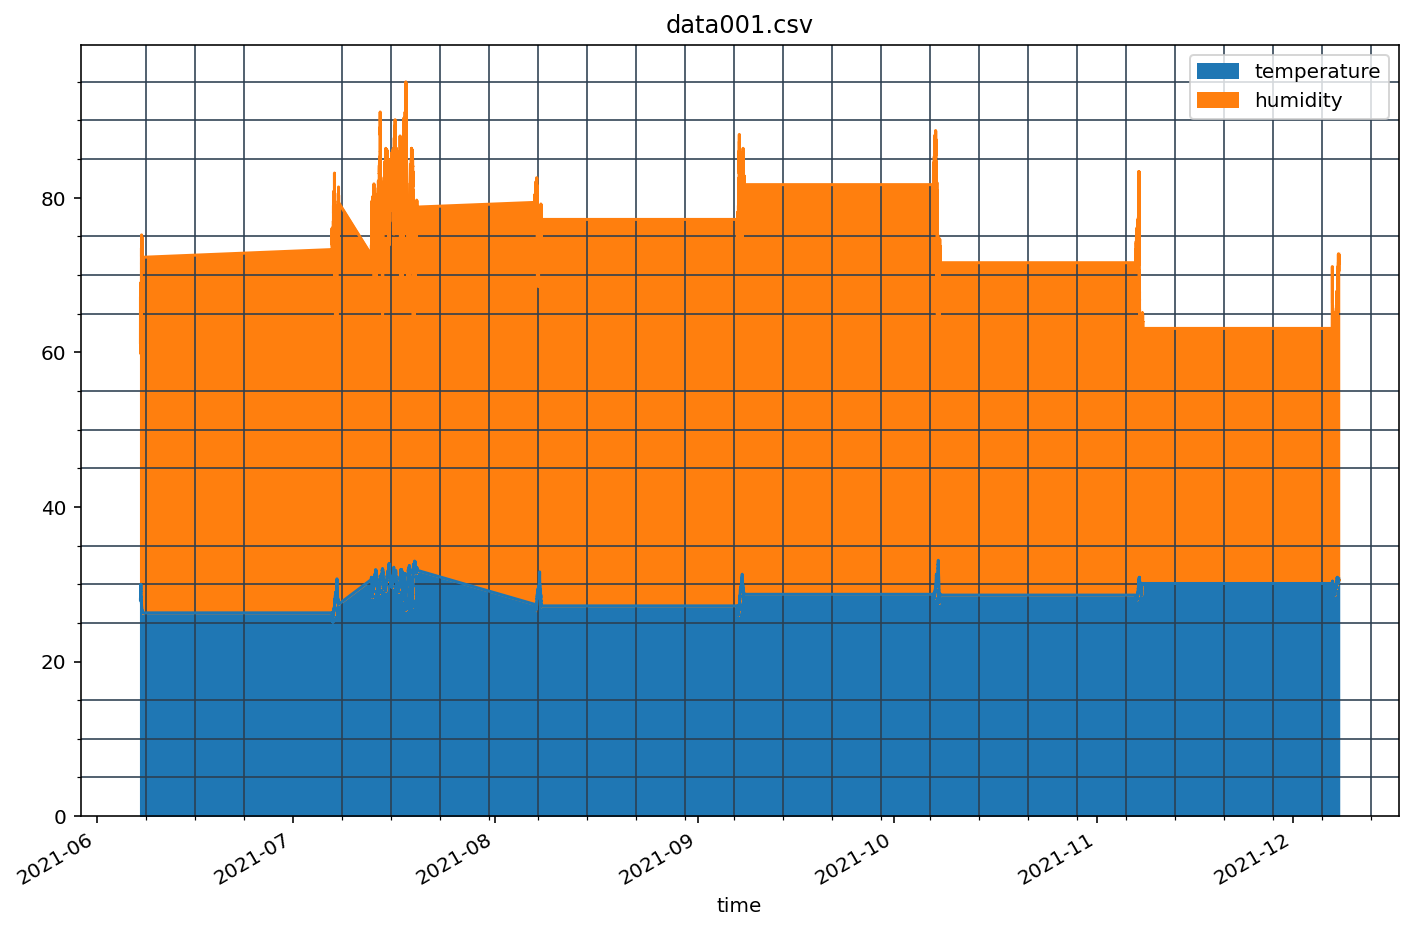

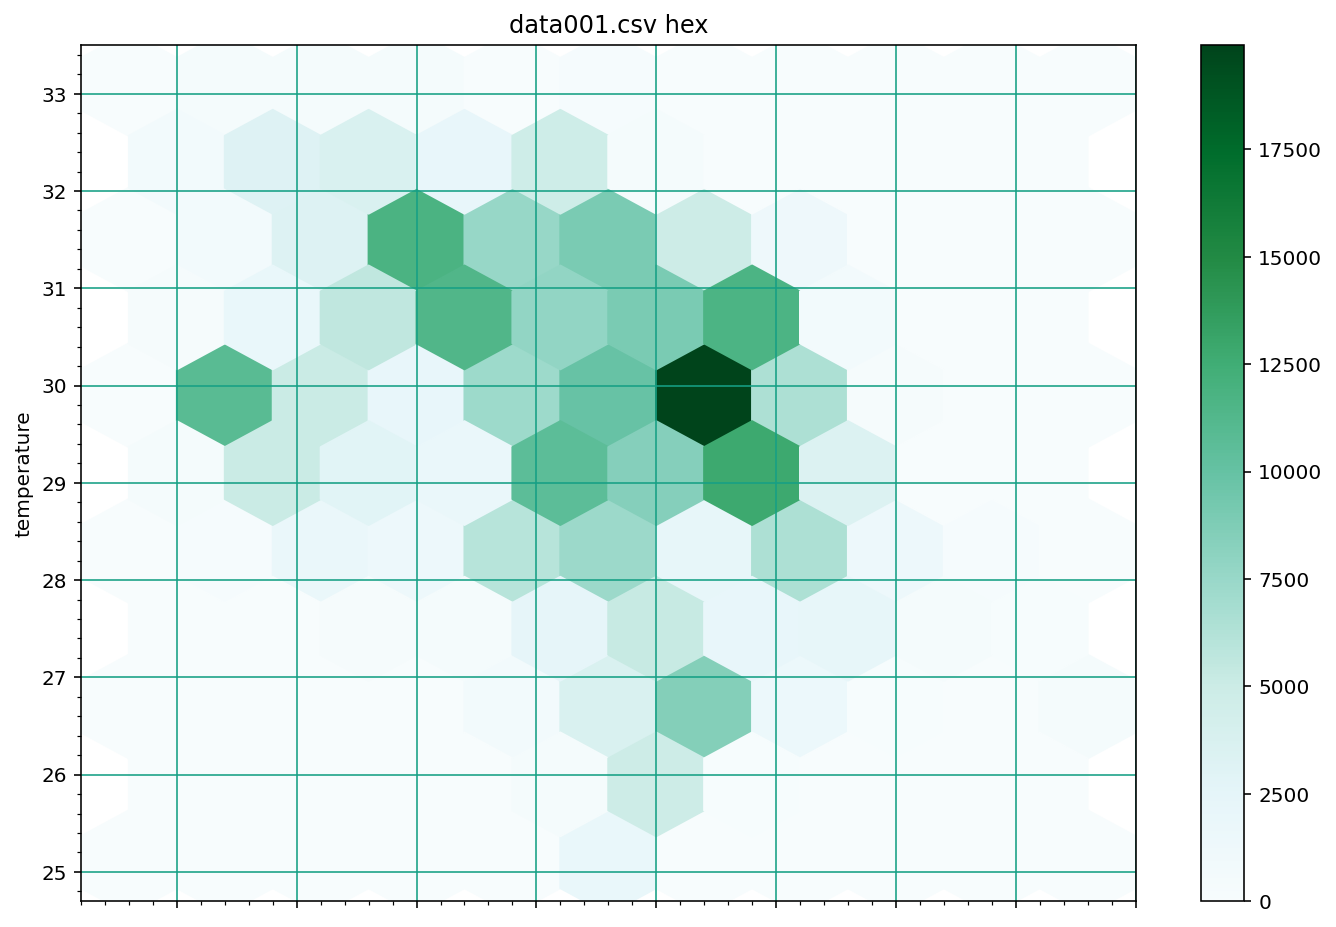

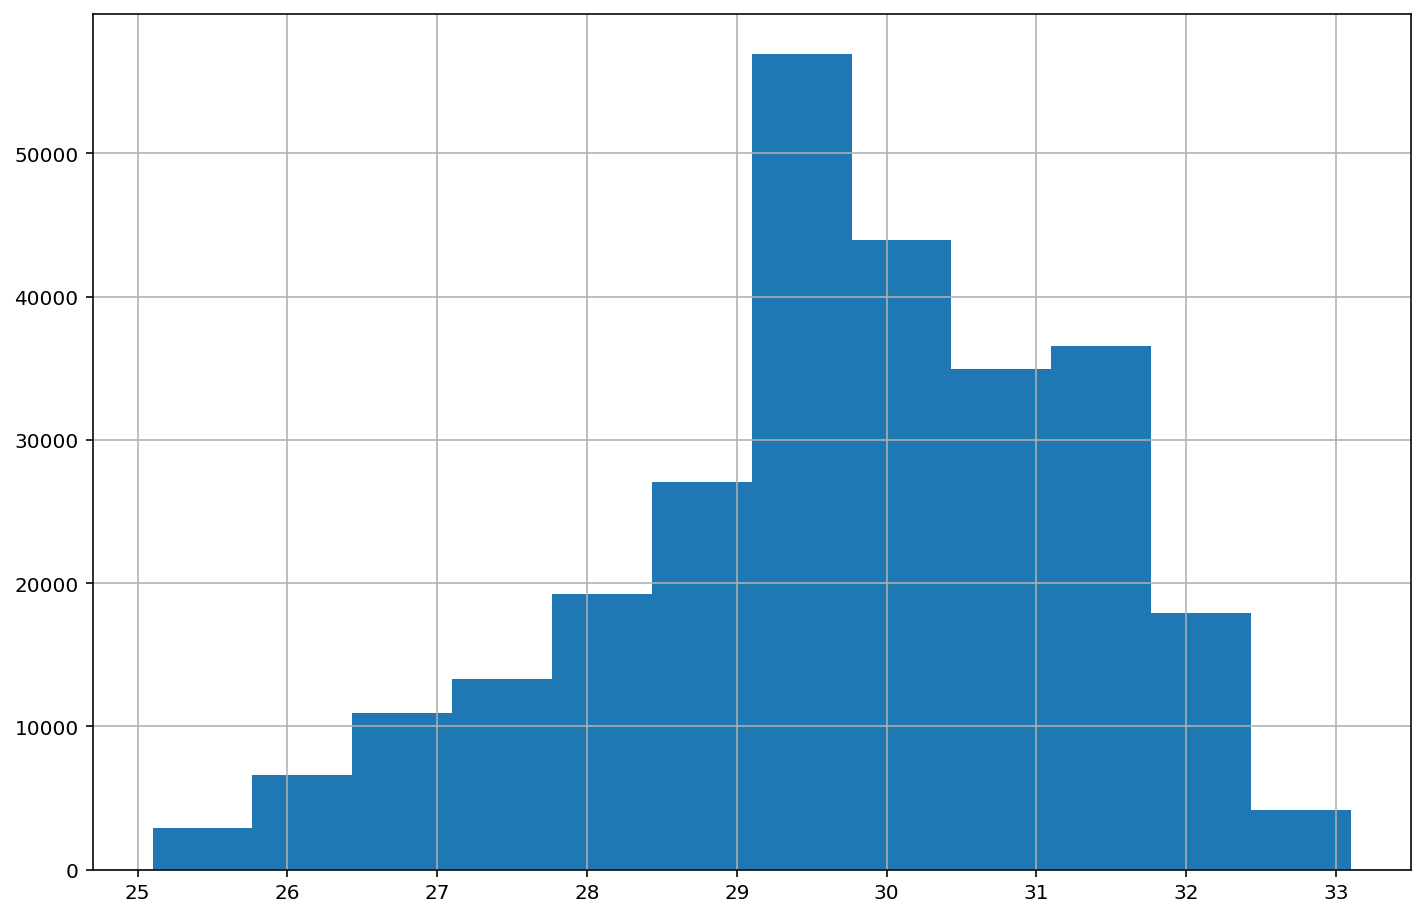

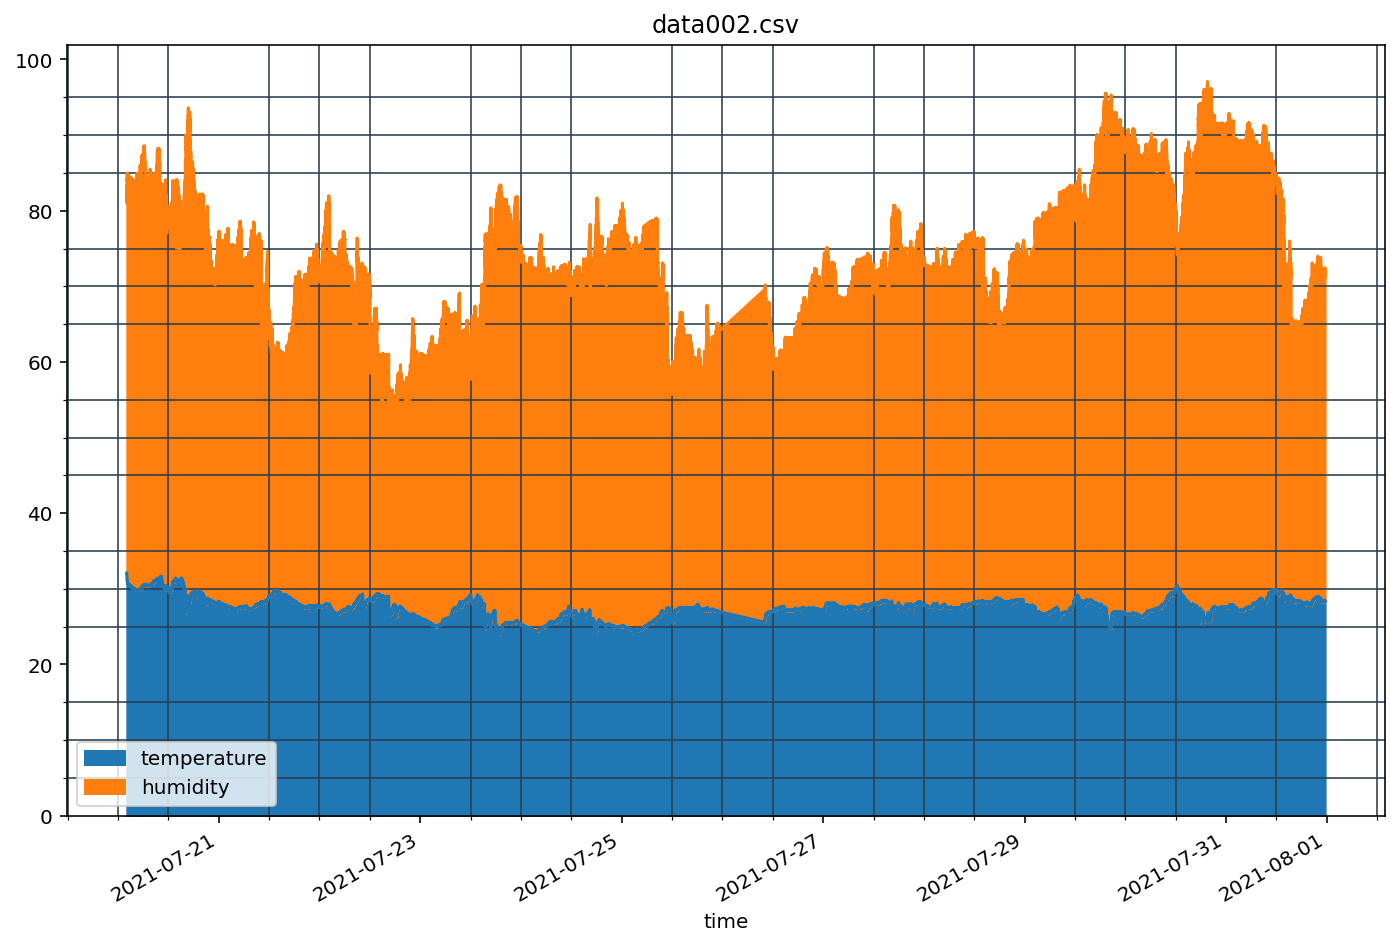

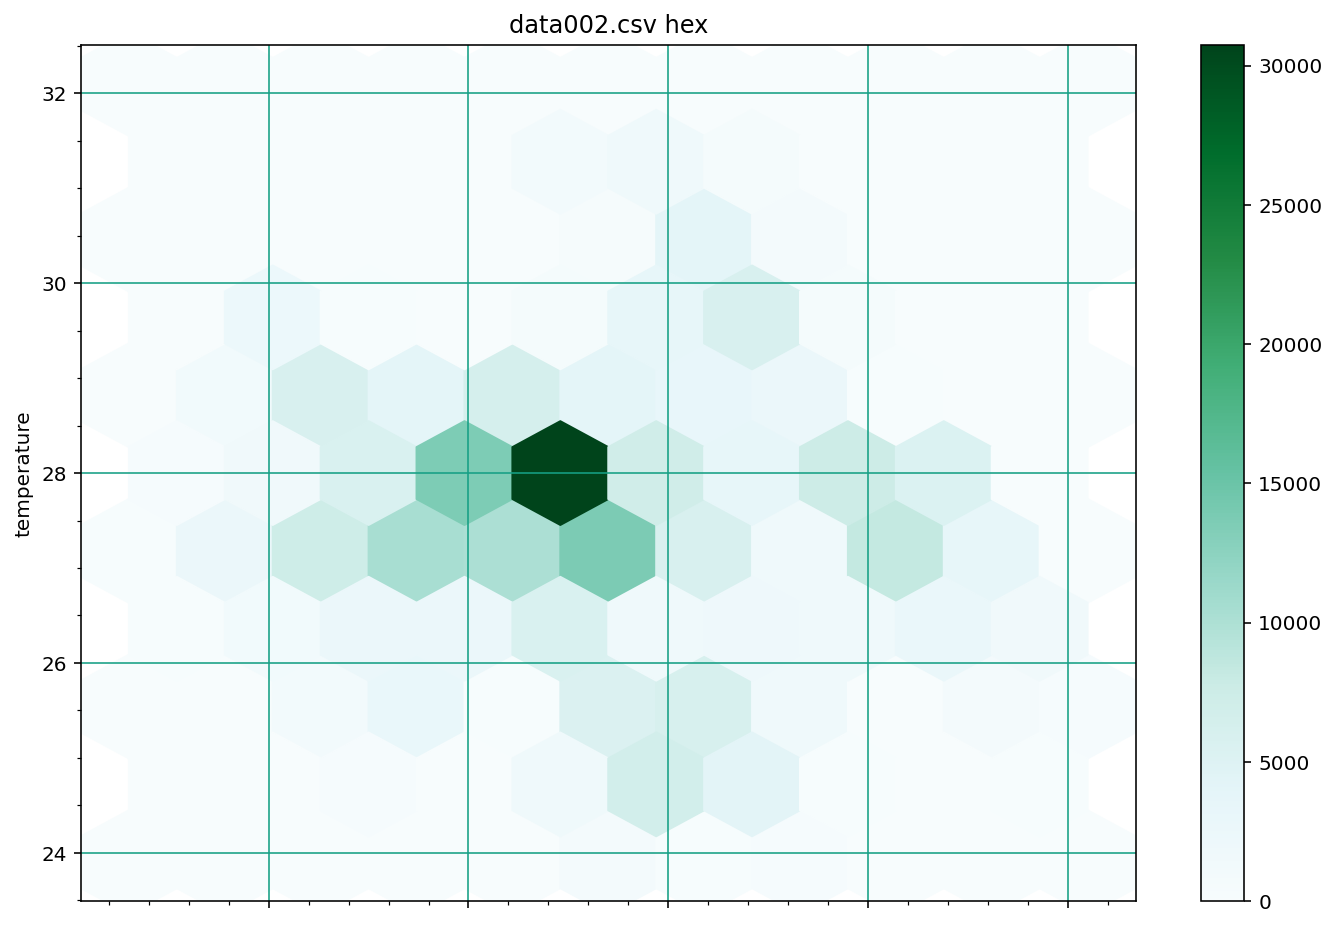

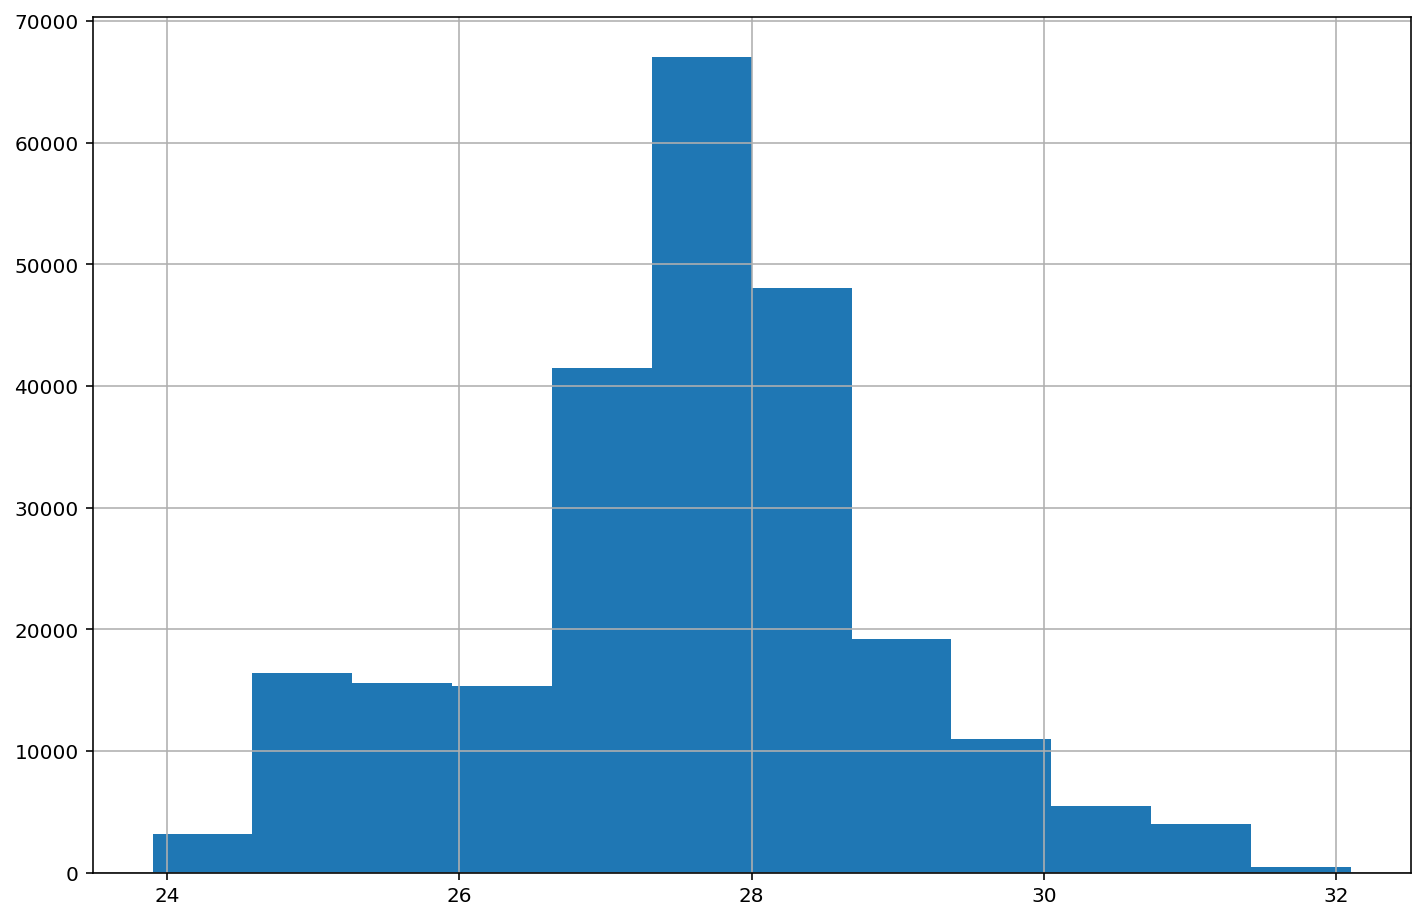

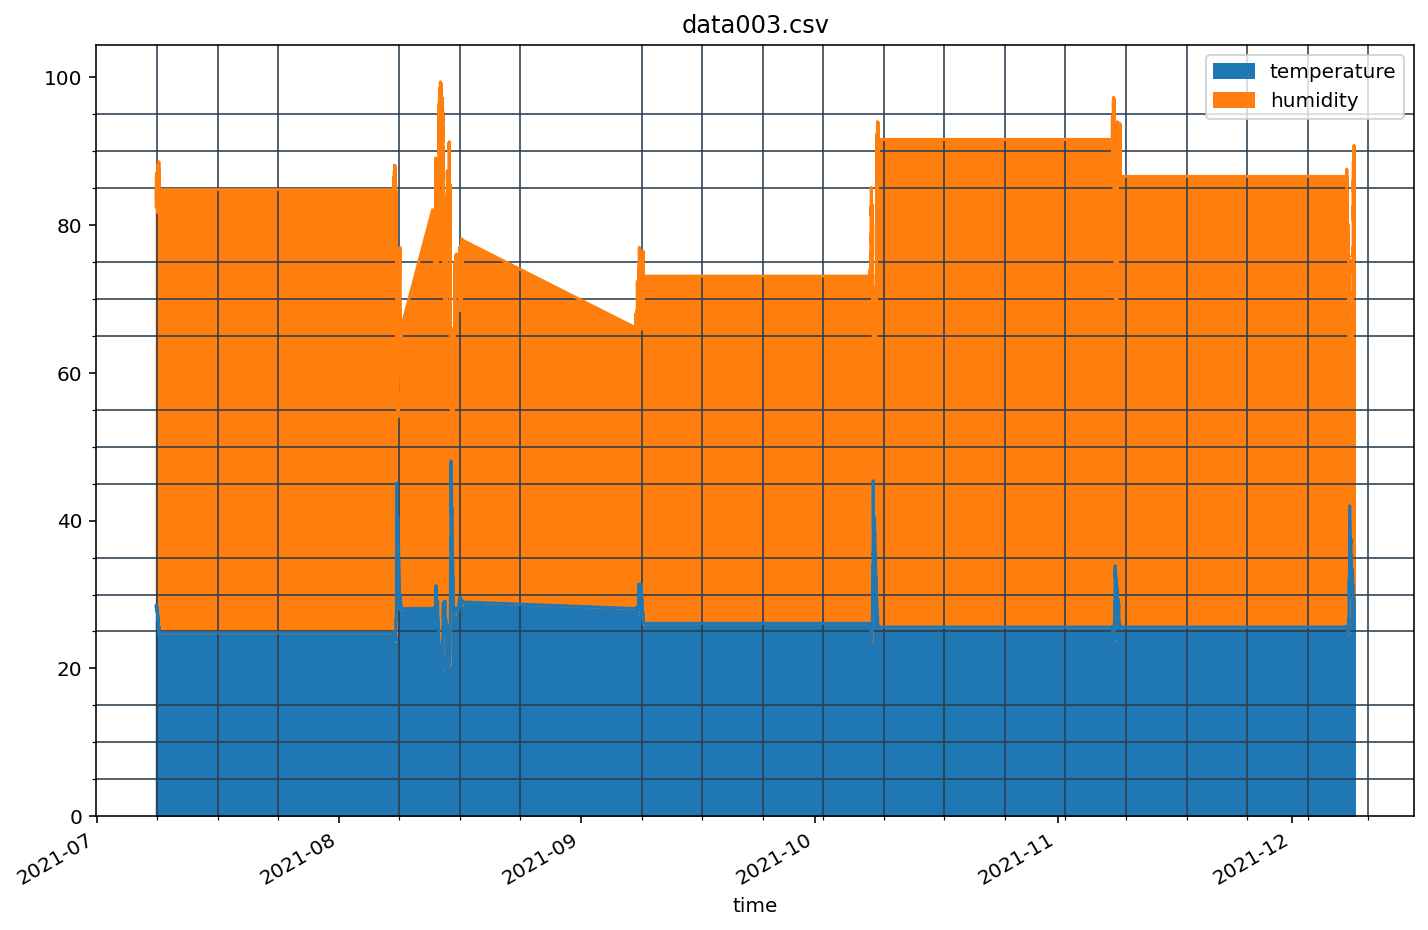

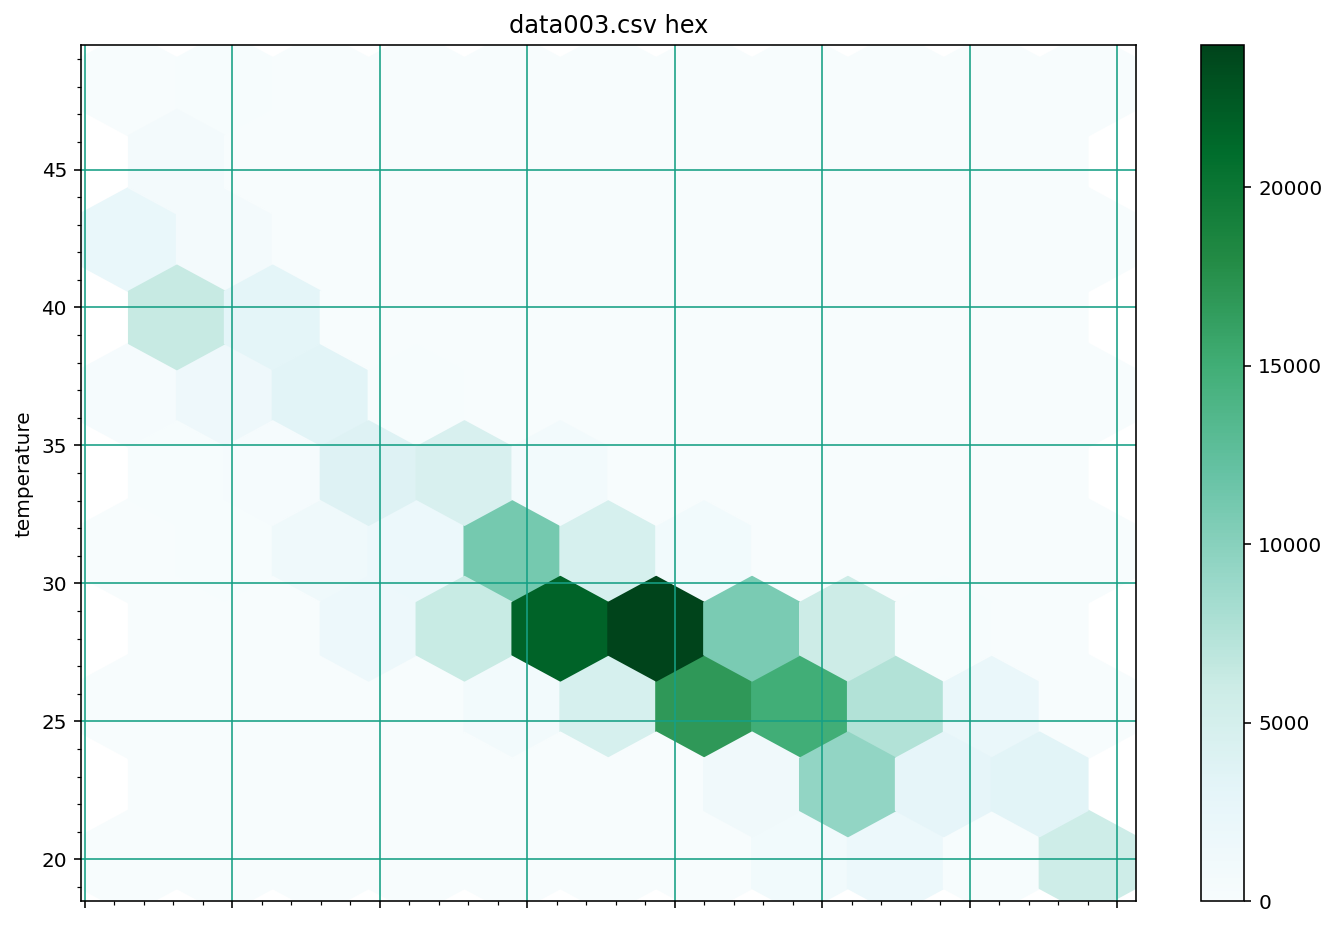

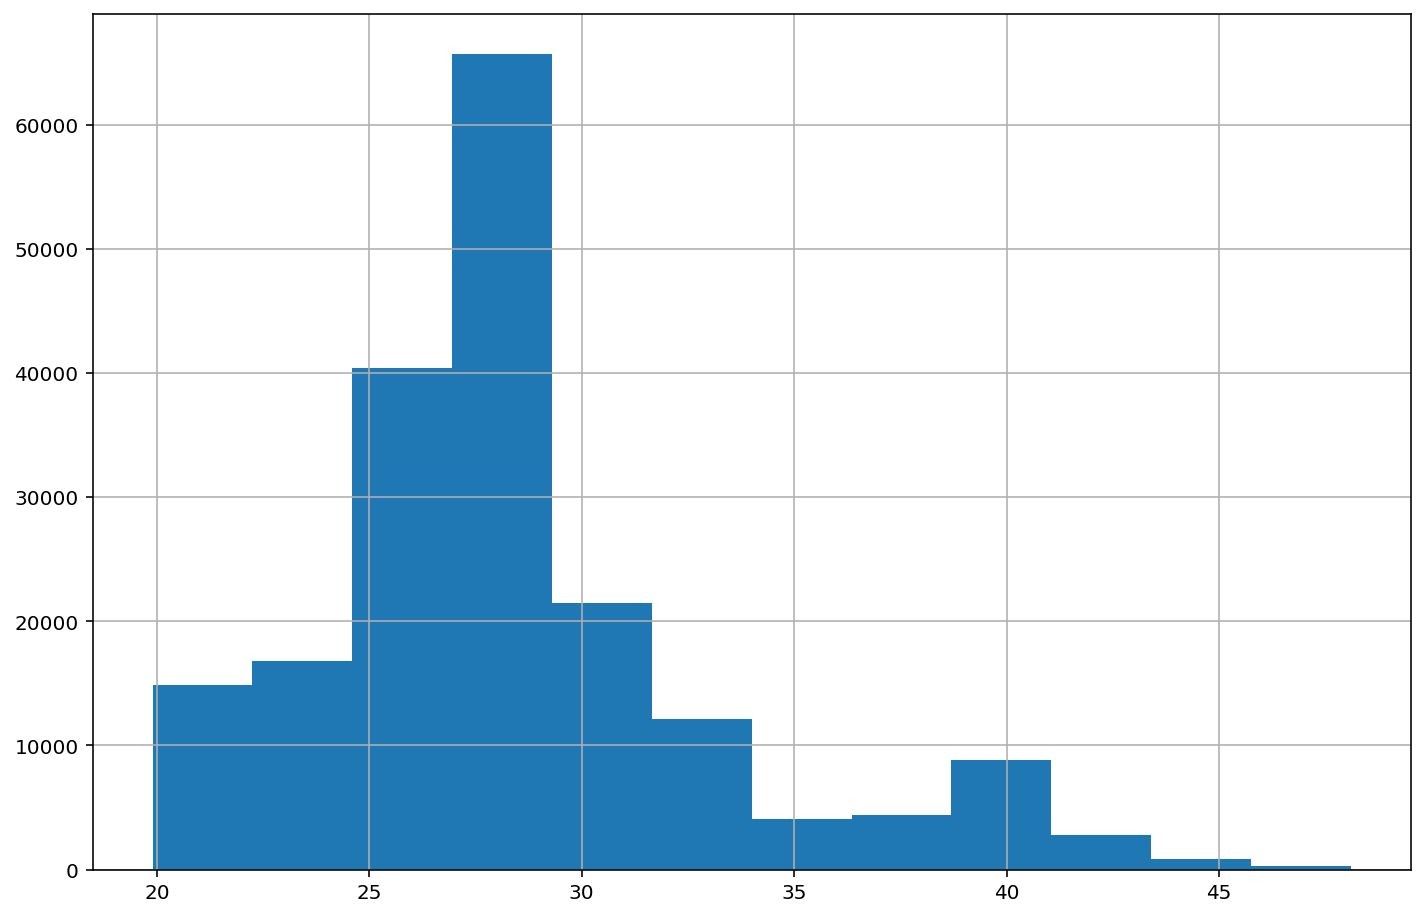

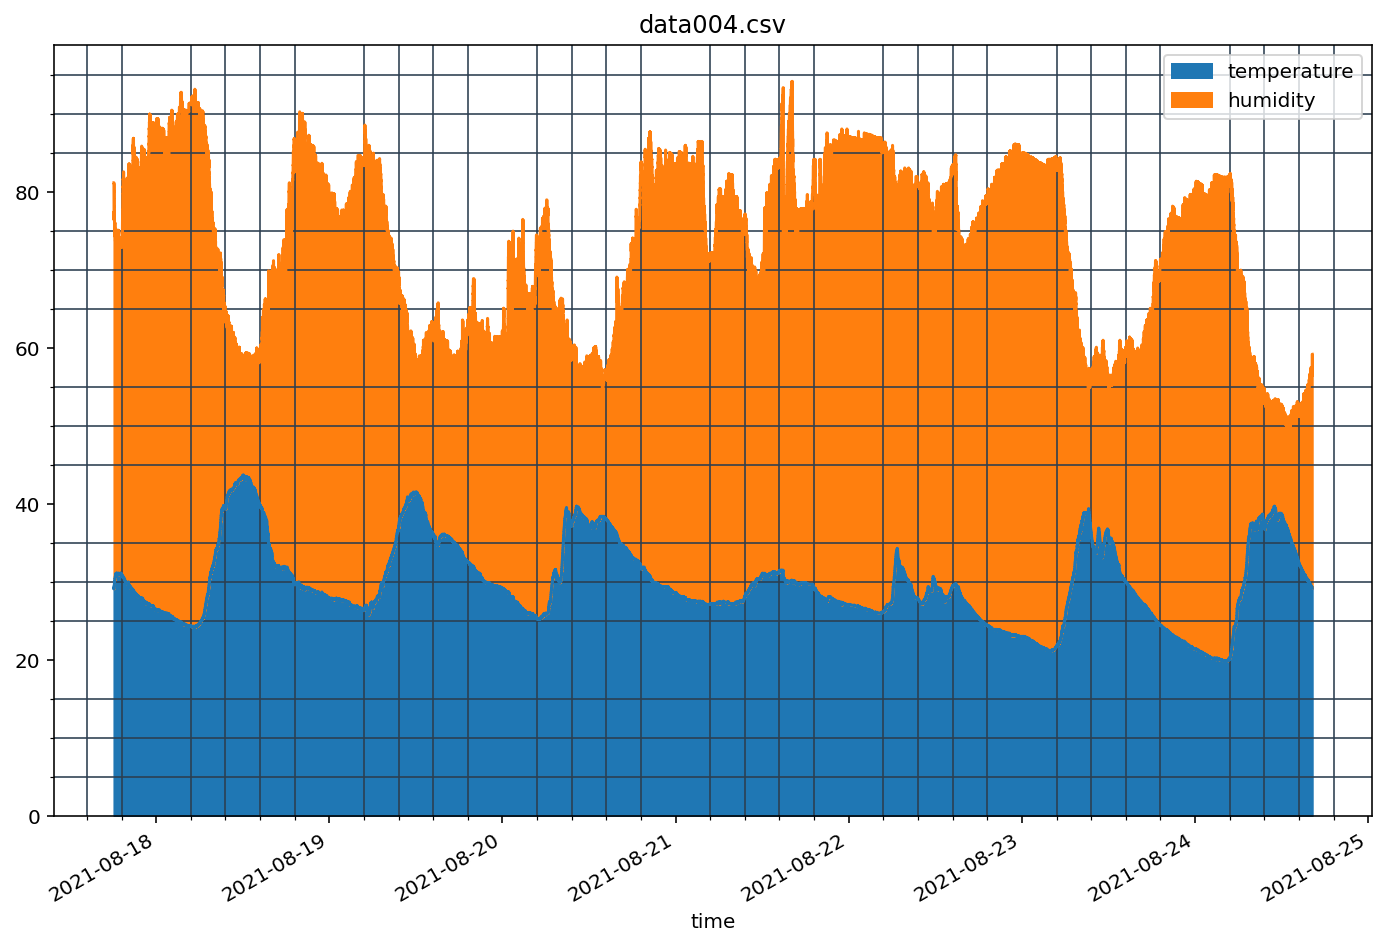

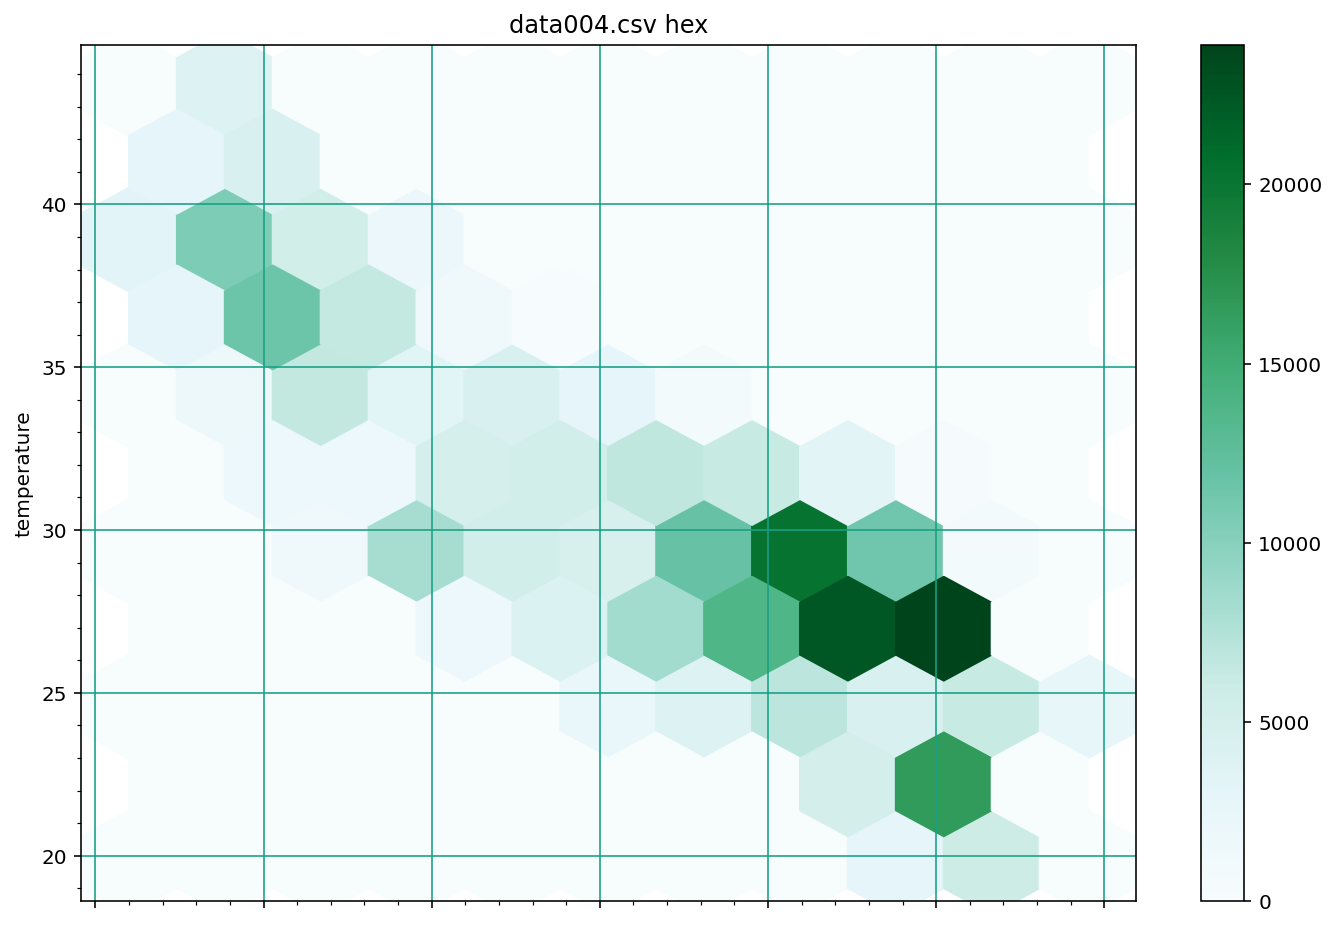

CPU times: user 17 s, sys: 220 ms, total: 17.2 s
Wall time: 17.2 s


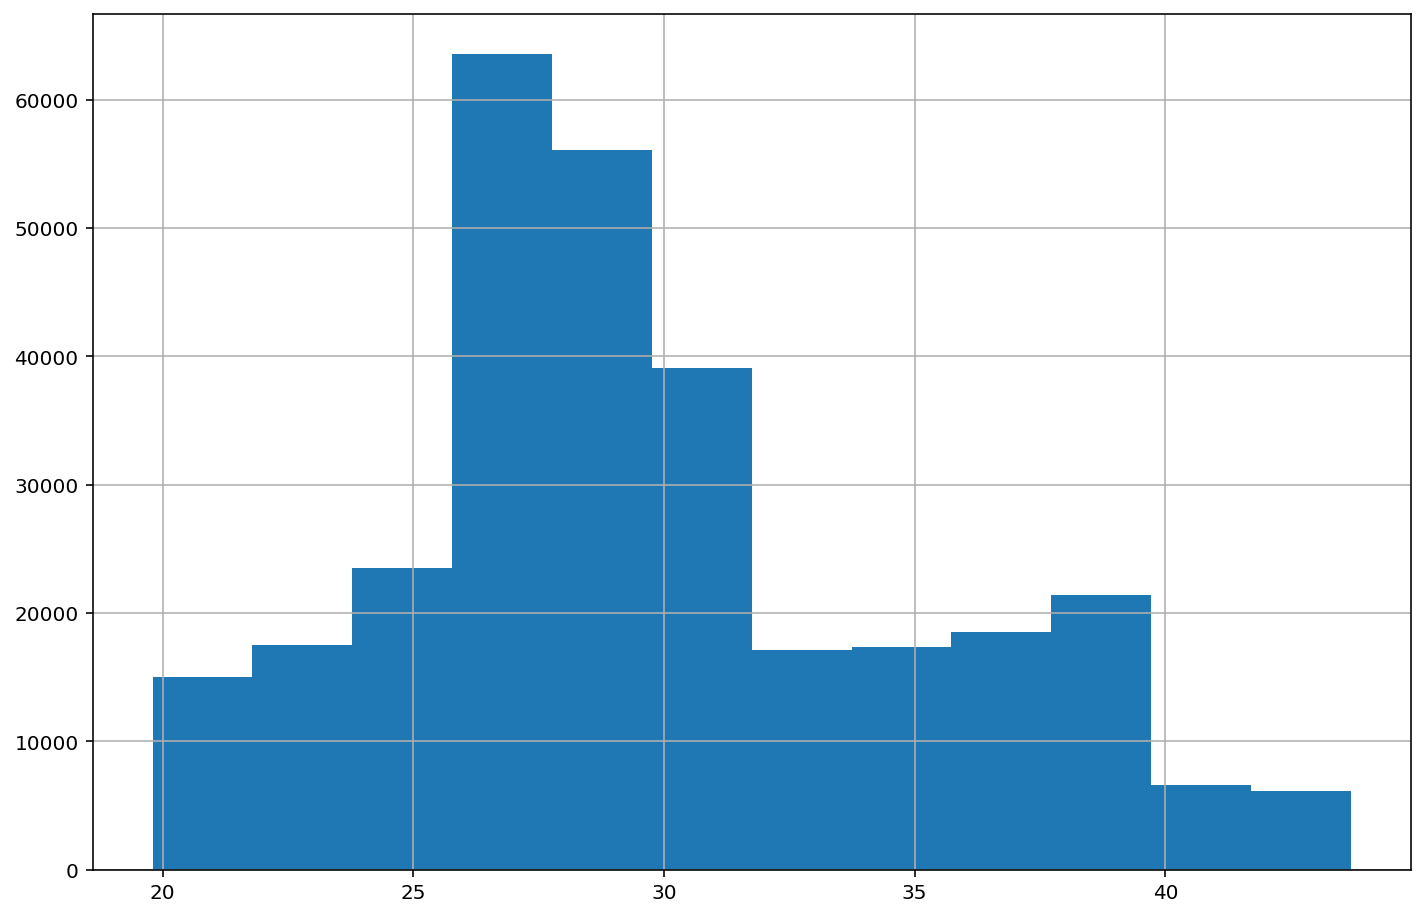

In [8]:
%%time
i = 0

for frame in frames:
    frame.plot.area(x="time", y=["temperature", "humidity"])
    plt.title(data_files[i])
    plt.grid(b=True, which='minor', color='#2c3e50')
    plt.minorticks_on()
    plt.show()
    
    frame.plot.hexbin(x="humidity", y="temperature", gridsize=10)
    
    plt.title("%s hex" % data_files[i])
    plt.grid(b=True, color='#16a085')
    plt.minorticks_on()
    plt.show()
    frame['temperature'].hist(bins=12)
    i += 1